In [1]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions

In [3]:
sparse_sessions.keys()

dict_keys(['SparseKO_05', 'SparseKO_02', 'SparseKO_03', 'SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

In [232]:
mouse = 'SparseKO_06'
d = sparse_sessions[mouse][-1]
print(d)

{'date': '05_06_2025', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 16, 'novel_arm': 1, 'exp_day': 8}


In [233]:
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
print(scene)
basedir = f'Z://giocomo/InVivoDA/2P_Data/{mouse}/{date}/{scene}'
stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })

YMaze_LNovel_LongTimeout


In [234]:
sess = stx.session.YMazeSession(**d)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P()
sess.load_suite2p_data(which_ts=('F', 'Fneu'))
sess.get_trial_info()


Fixing teleports
frame rate 15.625
(215944,) ttl times,(48413,) ca2+ frame times
last time: VR 3098.4853749999997, ca2+ 3098.368


c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:259: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:265: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


['Z://giocomo/InVivoDA/2P_Data/SparseKO_06/05_06_2025/YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_016\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_06/05_06_2025/YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_016\\chan2/suite2p']
1
2
3
4
5
6
7


In [235]:
F = sess.timeseries['channel_0_F']
trial_ts = np.zeros([F.shape[-1],])-1
blocknum_ts = np.zeros([F.shape[-1],])-1 
for t, (start,stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
    trial_ts[start:stop] = t
    blocknum_ts[start:stop]=sess.trial_info['block_number'][t]
mask_920 = (blocknum_ts%2==0)*(blocknum_ts>0)
mask_1040 = (blocknum_ts%2==1)*(blocknum_ts>0)

In [236]:

# sig920 = sess.timeseries['channel_0_F'][:, mask_920].sum(axis=-1)
# sig1040 = sess.timeseries['channel_0_F'][:, mask_1040].sum(axis=-1)
# channel_0_mask = sig920>(0.2*sig1040)
# sess.timeseries['channel_0_F'] = sess.timeseries['channel_0_F'][channel_0_mask,:]
# sess.timeseries['channel_0_Fneu'] = sess.timeseries['channel_0_Fneu'][channel_0_mask,:]

# sig920 = sess.timeseries['channel_1_F'][:, mask_920].sum(axis=-1)
# sig1040 = sess.timeseries['channel_1_F'][:, mask_1040].sum(axis=-1)
# channel_1_mask = sig1040>sig920
# sess.timeseries['channel_1_F'] = sess.timeseries['channel_1_F'][channel_1_mask,:]
# sess.timeseries['channel_1_Fneu'] = sess.timeseries['channel_1_Fneu'][channel_1_mask,:]



165 5524
6461 13749
14685 21176
22111 27526
28459 32961
33895 38090
39025 43626
44563 48412
165 5524
6461 13749
14685 21176
22111 27526
28459 32961
33895 38090
39025 43626
44563 48412


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


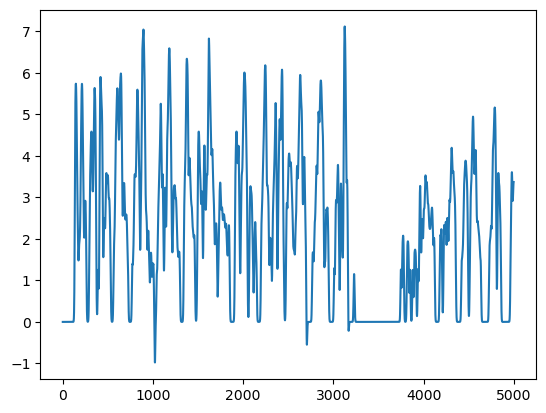

In [237]:
sess.neuropil_corrected_dff(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                            spks_key='channel_0_spks')
sess.neuropil_corrected_dff(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                            spks_key='channel_1_spks')

sess.add_timeseries(licks=sess.vr_data['lick']._values)
sess.add_pos_binned_trial_matrix('licks')
speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries(speed=speed)
sess.add_pos_binned_trial_matrix('speed')

fig,ax = plt.subplots()
ax.plot(speed[:5000])


spks = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')


spks = np.copy(sess.timeseries['channel_1_F_dff'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

# normalized spks (for activity analysis) 
sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix('channel_1_spks_norm')

spks = np.copy(sess.timeseries['channel_0_spks'])
sess.add_timeseries(channel_0_spks_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_spks_speed_filt')
spks = np.copy(sess.timeseries['channel_1_spks'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_spks_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_spks_speed_filt')

In [238]:
mask_920 = sess.trial_info['block_number']%2==0
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, trial_mask=mask_920)
mask_1040 = sess.trial_info['block_number']%2==1
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, trial_mask=mask_1040)

perm 0
perm 0
perm 0
perm 0


In [239]:
# create mask for place cells only 
def make_mask(sess): 
    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

    # mask for interneurons
    int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    chan1_mask = np.logical_and(chan1_mask, int_mask1)
    chan0_mask = np.logical_and(chan0_mask, int_mask0)

    chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
    chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
    chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
    chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
    
    sess.place_cell_info['channel_0_F_dff']['left']['masks'] = chan0_left_mask
    sess.place_cell_info['channel_0_F_dff']['right']['masks'] = chan0_right_mask
    sess.place_cell_info['channel_1_F_dff']['left']['masks'] = chan1_left_mask
    sess.place_cell_info['channel_1_F_dff']['right']['masks'] = chan1_right_mask
make_mask(sess)

In [181]:
sess.trial_info['block_number']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [240]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
tpu.sess.save_session(sess,output_path)

In [114]:
# load 
mouse = 'SparseKO_06'
d = sparse_sessions[mouse][-1]
date = d['date']
scene = d['scene']
session = d['session']
pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)

In [167]:
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma",aspect = 'auto',interpolation='none')

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    # fig.subplots_adjust(hspace=.3)
    return fig
chan0_left_mask = sess.place_cell_info['channel_0_F_dff']['left']['masks'] 
chan0_right_mask = sess.place_cell_info['channel_0_F_dff']['right']['masks'] 
chan1_left_mask = sess.place_cell_info['channel_1_F_dff']['left']['masks'] 
chan1_right_mask=sess.place_cell_info['channel_1_F_dff']['right']['masks'] 

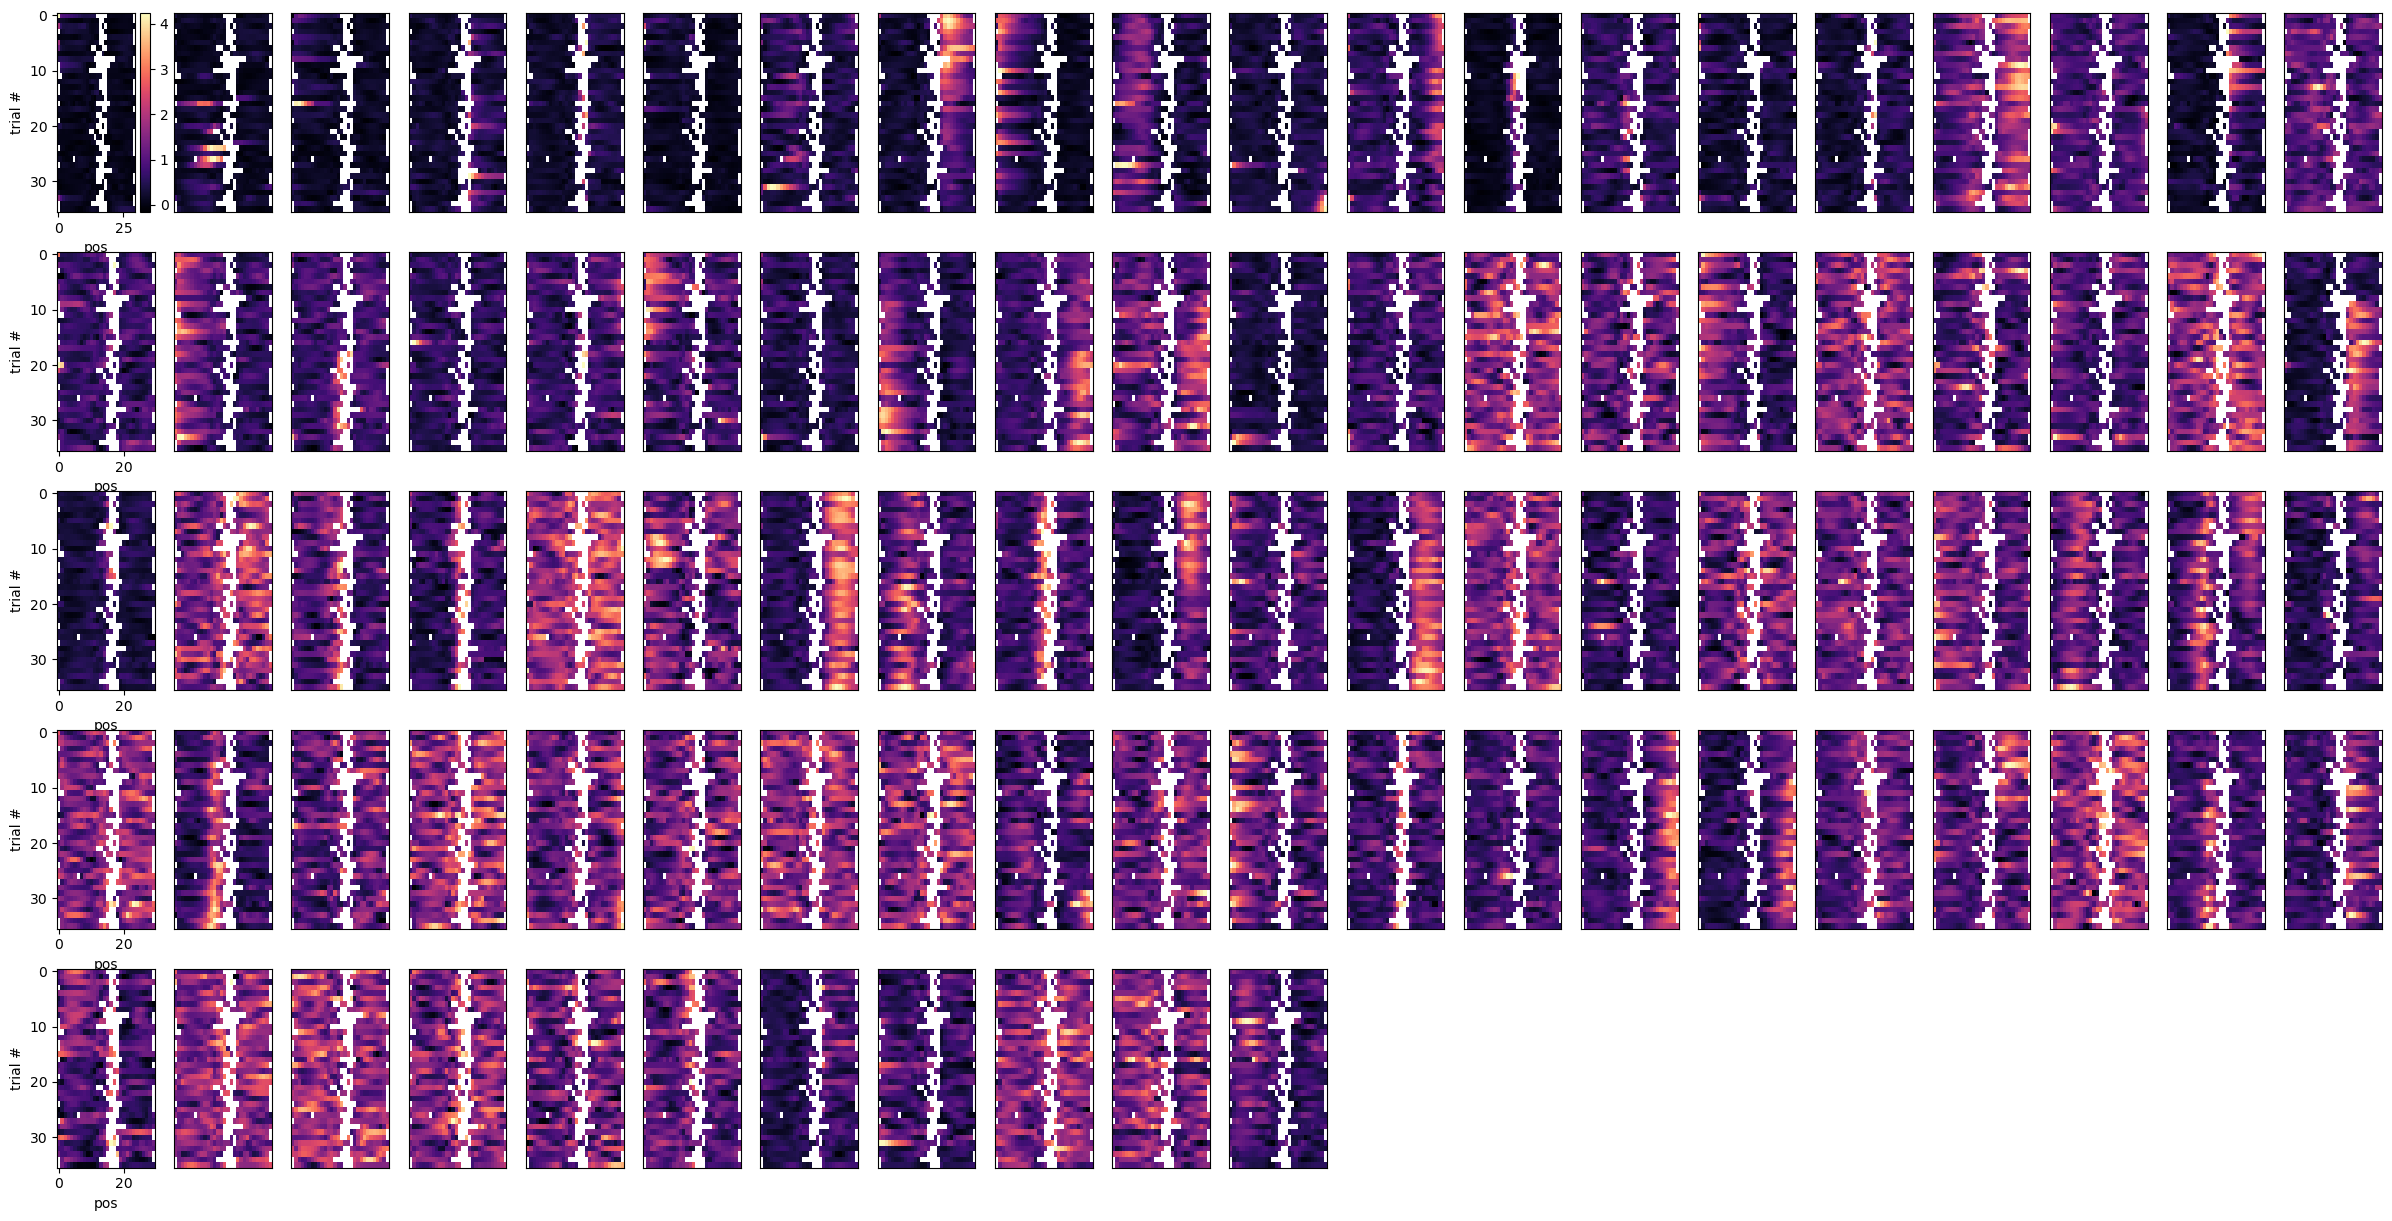

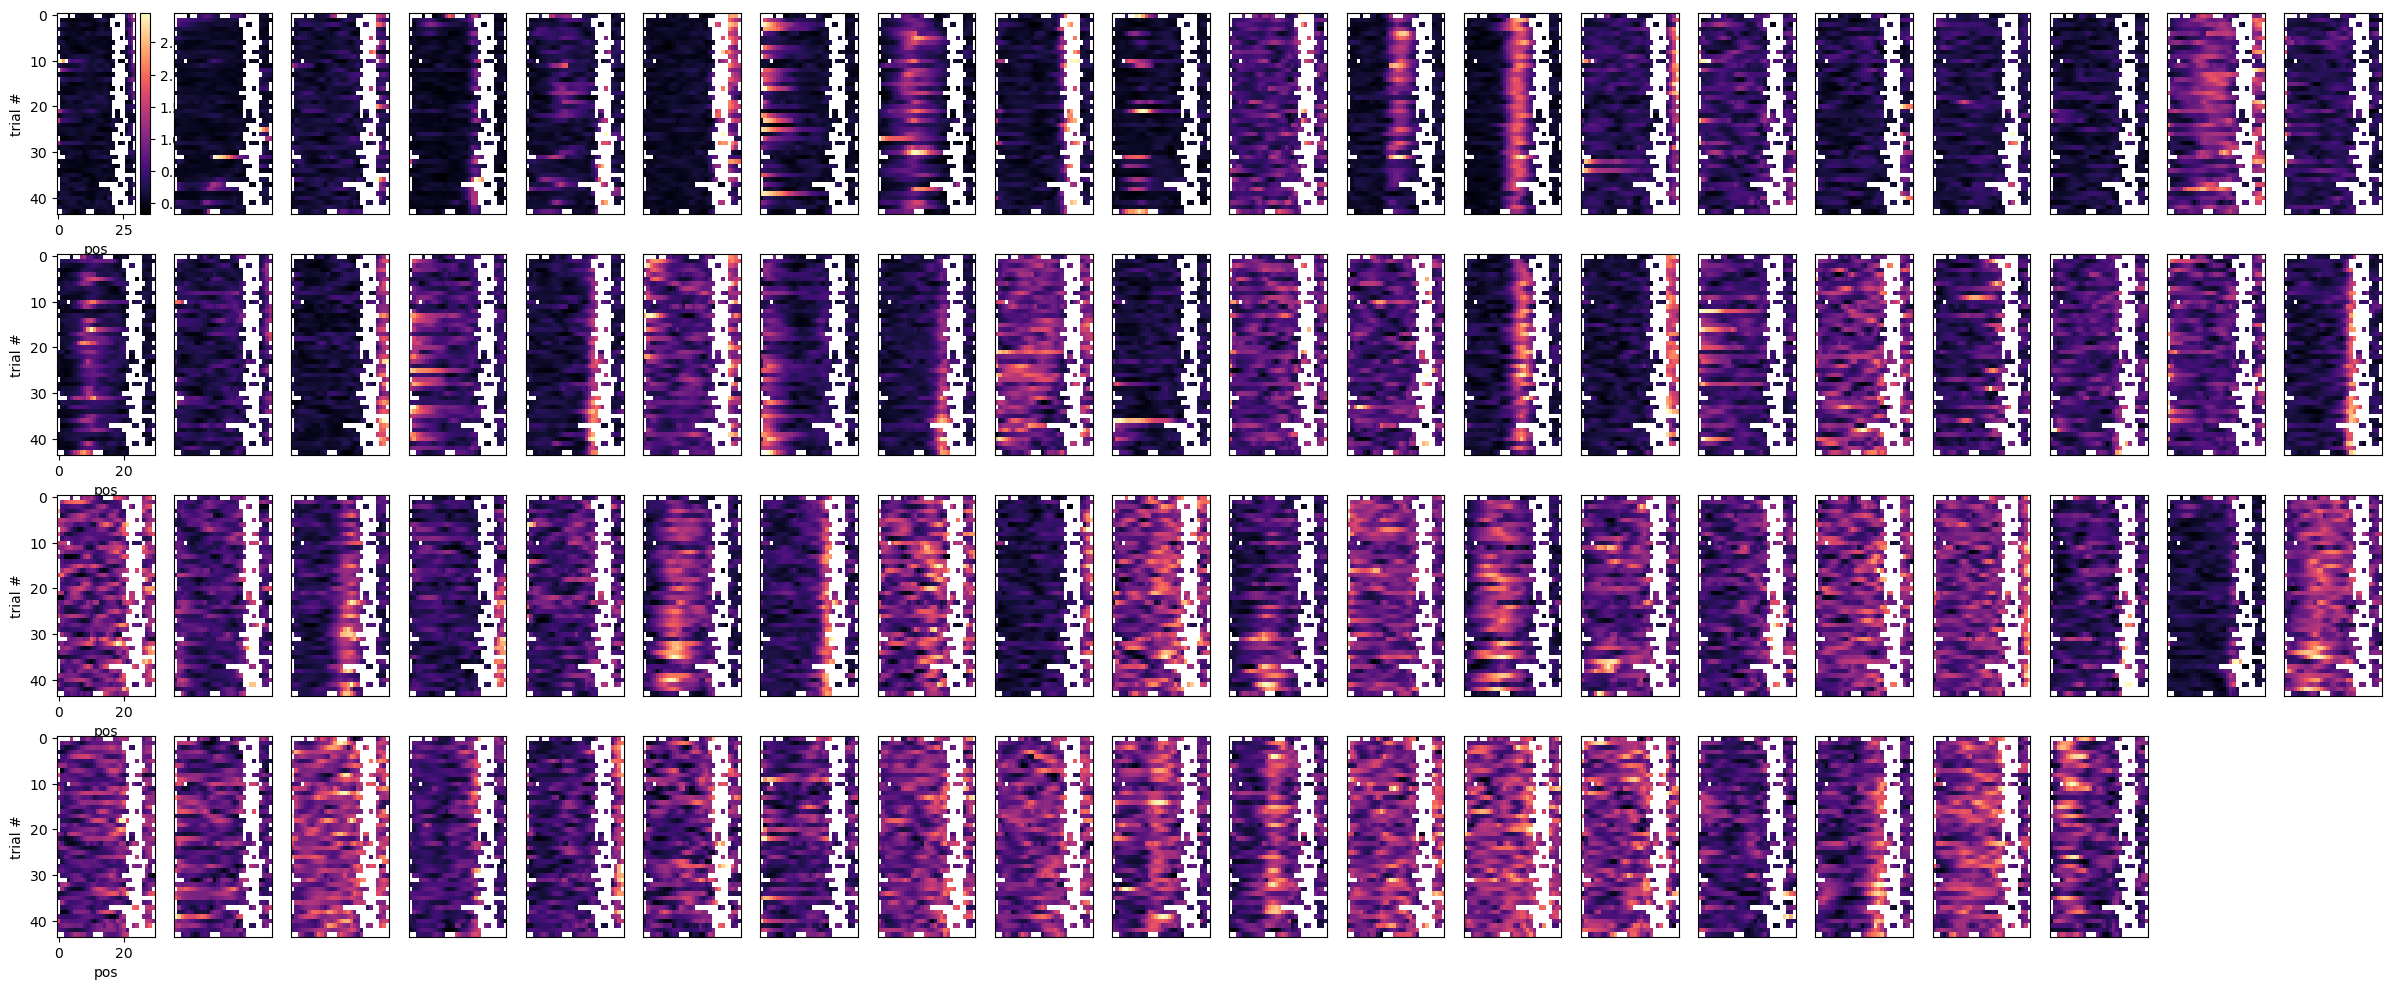

In [173]:
trial_mask = (sess.trial_info['LR']==-1)*((sess.trial_info['block_number']%2)==1)
tmat = sess.trial_matrices['channel_1_F_dff_speed_filt']
n_cells = tmat.shape[-1]
pc_idx = np.where(chan1_left_mask[:n_cells])[0]
# fig = plot_cells(tmat, cell_inds=pc_idx)
fig = plot_cells(tmat[trial_mask,:,:], cell_inds=pc_idx)

trial_mask = (sess.trial_info['LR']==1)*((sess.trial_info['block_number']%2)==1)
tmat = sess.trial_matrices['channel_1_F_dff_speed_filt']
n_cells = tmat.shape[-1]
pc_idx = np.where(chan1_right_mask[:n_cells])[0]

fig = plot_cells(tmat[trial_mask,:,:], cell_inds=pc_idx)

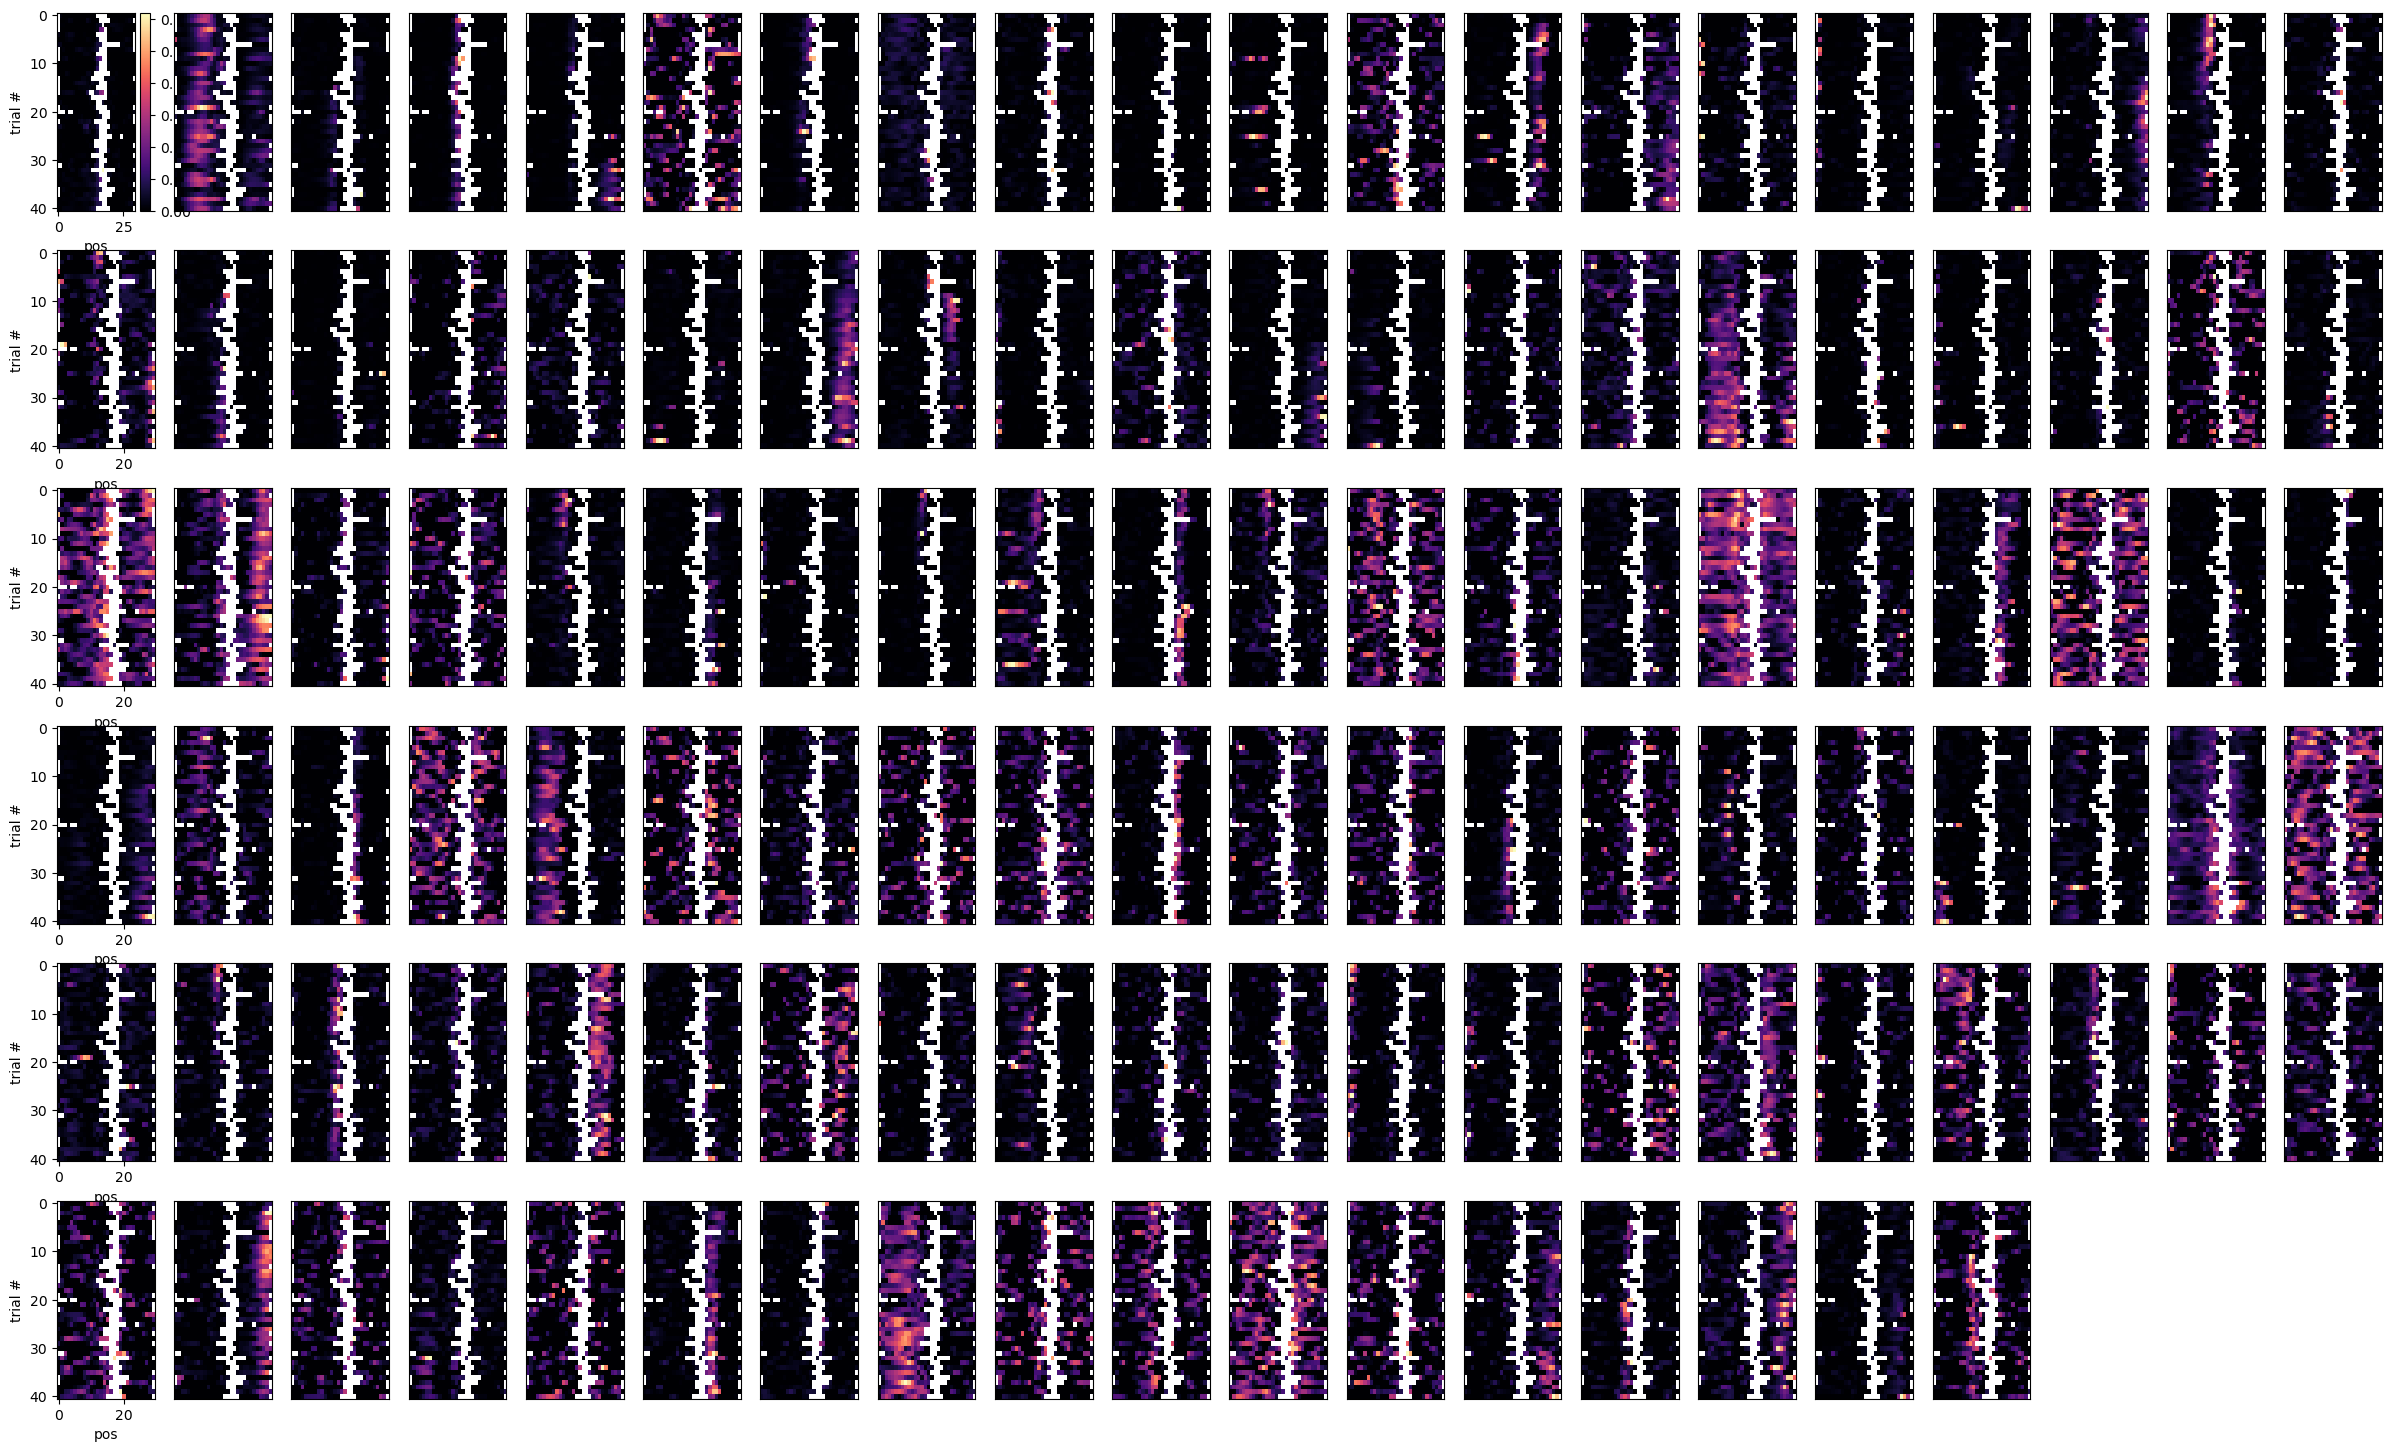

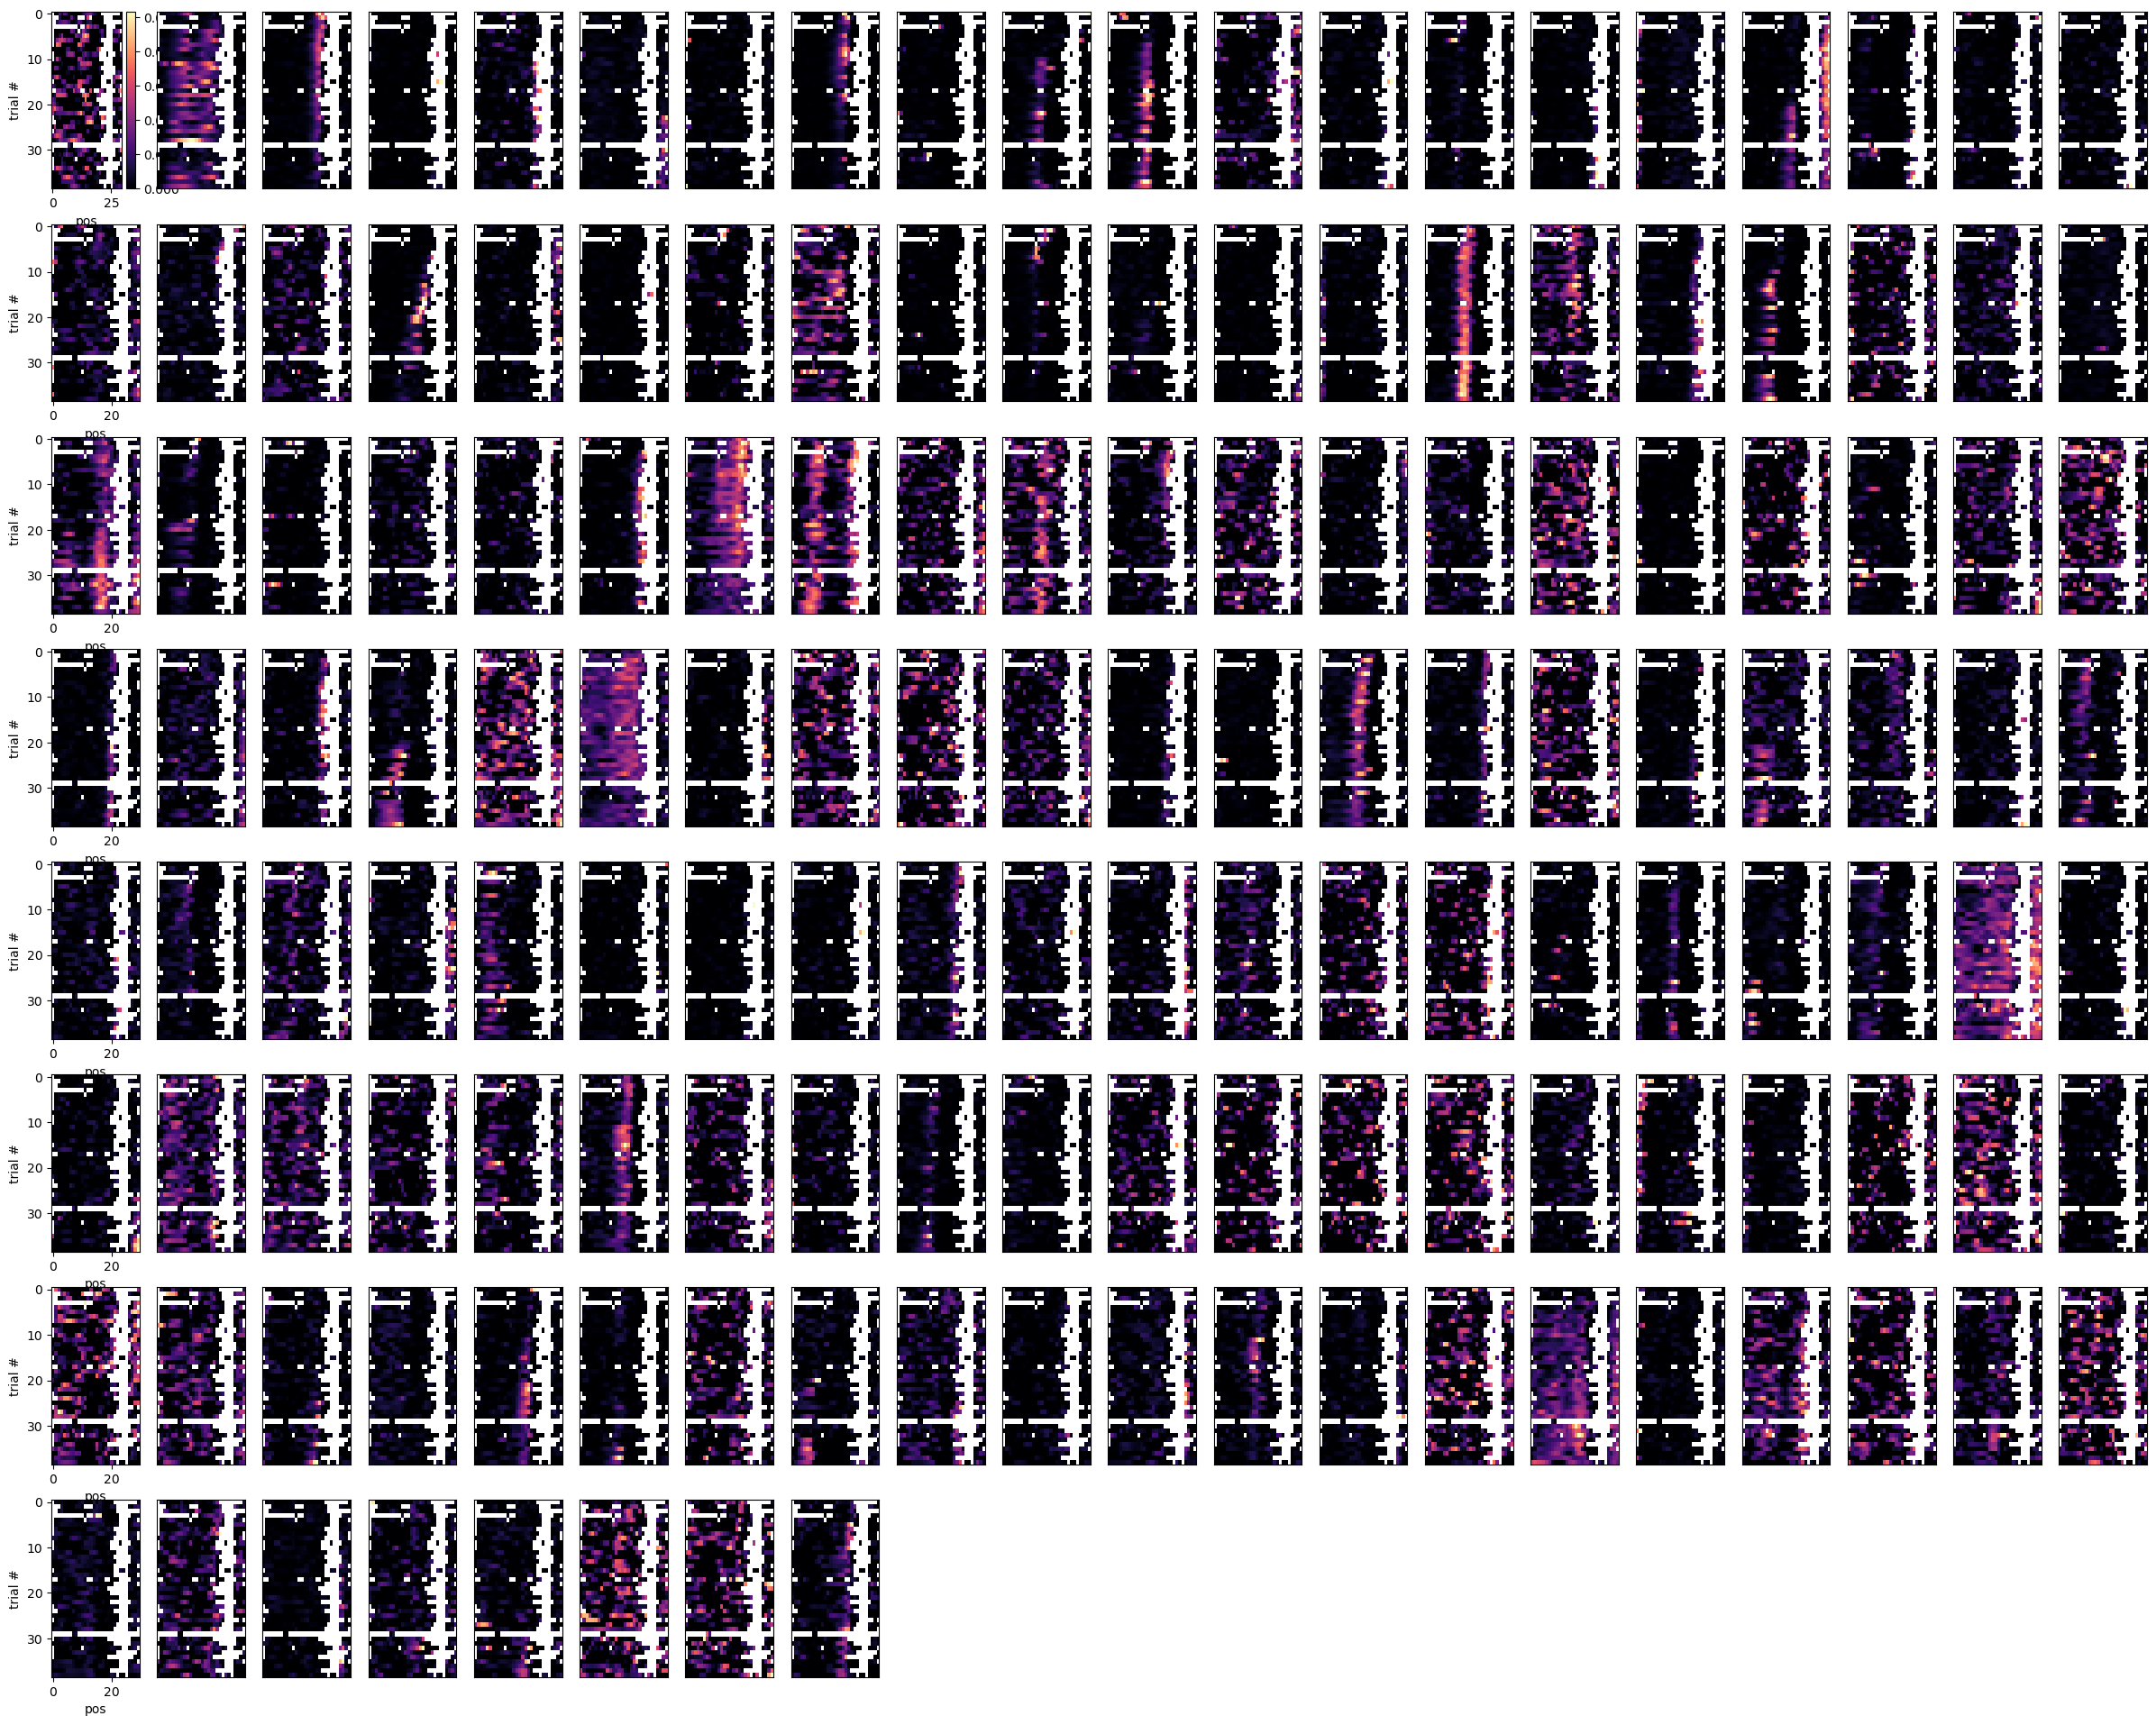

In [172]:
trial_mask = (sess.trial_info['LR']==-1)*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_0_spks_speed_filt']
n_cells = tmat.shape[-1]
pc_idx = np.where(chan0_left_mask[:n_cells])[0]


fig = plot_cells(tmat[trial_mask,:,:], cell_inds=pc_idx)

trial_mask = (sess.trial_info['LR']==1)*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_0_spks_speed_filt']
n_cells = tmat.shape[-1]

pc_idx = np.where(chan0_right_mask[:n_cells])[0]

fig = plot_cells(tmat[trial_mask,:,:], cell_inds=pc_idx)

In [19]:
chan0_blocks = sess.trial_info['block_number']%2==0
chan0sig = np.nansum(np.nansum(sess.trial_matrices['channel_1_spks'][chan0_blocks,:,:],axis=0), axis=0)
chan1sig = np.nansum(np.nansum(sess.trial_matrices['channel_1_spks'][~chan0_blocks,:,:],axis=0), axis=0)

(chan1sig>chan0sig).sum()

137

### attempt to plot timeseries (fail)

In [ ]:


sess = u.load_single_day(mouse,day)
trial_masks = make_masks(sess)

if fam:
    if sess.novel_arm== 1: #changed from -1 (typo??) to 1 
        key = 'right'
    else:
        key = 'left'
else:
    if sess.novel_arm == -1:
        key='left'
    else:
        key='right'
        
thresh = np.percentile(sess.place_cell_info['channel_0_F_dff'][key]['SI'], pc_thresh)
            
    
pc_mask = sess.place_cell_info['channel_0_F_dff'][key]['masks'] & (sess.place_cell_info['channel_0_F_dff'][key]['SI']>thresh)

avg_trial_mat = np.nanmean(sess.trial_matrices['channel_0_spks'][sess.trial_info['LR']==((-1*fam) + 1*(1-fam))*sess.novel_arm,:,:], axis=0)
avg_trial_mat = avg_trial_mat[:, pc_mask]

sort = np.argsort(np.argmax(avg_trial_mat,axis=0))[::-1]
# make gridspec
fig = plt.figure(figsize=[12,5])
gs = gridspec.GridSpec(3,12)

reward = sess.vr_data['reward']
licks = sess.timeseries['licks'][0,:]
licks[licks>0]=1
licks[licks<1]=np.nan
# reward[reward<1]=np.nan



# nan ITI
t =  sess.vr_data['t']
for (stop, start) in zip(sess.teleport_inds[:-1], sess.trial_start_inds[1:]): #add mask for even/odd trials 
    t[stop:start] = np.nan

t_reward = 10*(t-sess.trial_matrices['bin_centers'][0])*reward
t_reward[t_reward<1]=np.nan

t_licks = 10*(t-sess.trial_matrices['bin_centers'][0])*licks
t_licks[t_licks<1]=np.nan
# t_reward = t_reward*10.

t_starts = sess.trial_start_inds[sess.trial_info['LR']==((-1*fam) + (1-fam))*sess.novel_arm]
t_stops = sess.teleport_inds[sess.trial_info['LR']==((-1*fam) + (1-fam))*sess.novel_arm]

start = t_starts[1]-10
stop = t_stops[8]+10

window = slice(start,stop)
spks = sess.timeseries['channel_0_spks'][pc_mask,:]
ax_spks = fig.add_subplot(gs[0:2,:11])
spks_toplot = spks[sort, window]
# keep = np.arange(spks_toplot.shape[1]) % 2 == 0
# spks_toplot = spks_toplot[:,keep]
img = ax_spks.imshow(spks_toplot, aspect='auto',cmap='Greys', vmax=.4)

ax_clrbr = fig.add_subplot(gs[0,11])
ax_clrbr.set_yticks([])
ax_clrbr.set_xticks([])
plt.colorbar(img,ax=ax_clrbr)

dt = 1./sess.scan_info['frame_rate']
x = np.arange(stop-start)
# set iti to nan for position
t = t[window] #sess.timeseries['t'][0,window]
t[t<sess.trial_matrices['bin_edges'][0]] = np.nan
t = 10*(t- sess.trial_matrices['bin_centers'][0])

ax_pos = fig.add_subplot(gs[2,:11], sharex=ax_spks)
ax_pos.plot(x, t)


ax_pos.scatter(x,t_reward[window], color='orange', zorder=10,s=80, marker='o')
ax_pos.scatter(x, licks[window]+10, color='red', zorder = 8, alpha=1, s=100, marker='|')


# for (start, stop) in zip(sess.trial_start_inds[1:9], sess.teleport_inds[1:9]):
#     ax_pos.plot([stop-sess.trial_start_inds[1]+10, stop-sess.trial_start_inds[1]+10],[0, 300], 'k--', alpha=.3)
#     ax_pos.plot([start-sess.trial_start_inds[1]+10, start-sess.trial_start_inds[1]+10],[0, 300], 'k--', alpha=.3)
for (stop, start) in zip(sess.teleport_inds[1:9], sess.trial_start_inds[2:9]):
    stop = stop - sess.trial_start_inds[1] +9
    start = start - sess.trial_start_inds[1] +9
    ax_pos.fill_betweenx([-10,300], stop, start, color='black', alpha=.3, edgecolor='white')
    
    # ax_pos.plot([stop-sess.trial_start_inds[1]+10, stop-sess.trial_start_inds[1]+10],[0, 300], 'k--', alpha=.3)
    # ax_pos.plot([start-sess.trial_start_inds[1]+10, start-sess.trial_start_inds[1]+10],[0, 300], 'k--', alpha=.3)

ax_spks.set_ylabel('Cells')
ax_pos.set_ylabel('Position')
ax_pos.set_xlabel('Time (s)')

labels = (dt*x)[::250]

ax_pos.set_xticks(x[::250], labels=[str(int(l)) for l in labels])

ax_pos.spines['top'].set_visible(False)
ax_pos.spines['right'].set_visible(False)
# ax_pos.set_ylim([310, -10])


fig.suptitle(f"mouse: {mouse}, day: {day}")

# outdir = "/mnt/BigDisk/YMazeResults/neural/example_place_cell_pop/"
# fig.savefig(outdir+f"example_pc_trials_{mouse}_day{day}.pdf")
